In [ ]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygad
from aiida.manage.configuration import load_profile
from aiida.orm import ArrayData, QueryBuilder
from aiida_aurora.calculations import BatteryCyclerExperiment
from aiida_aurora.data import BatterySampleData, CyclingSpecsData
from aiida_aurora.utils.parsers import get_data_from_results
from aiida_aurora.workflows import CyclingSequenceWorkChain
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

load_profile()


In [ ]:
pd.options.display.max_rows = 200


In [ ]:
%matplotlib widget
%matplotlib inline


In [854]:
generations = {
    "231012": {
        "formation_cycles": 3,
        "additive": {
            "type": "VC",
            "amount": "2",
        },
    },
    "231018": {
        "formation_cycles": 2,
        "additive": {
            "type": "VC",
            "amount": "2",
        },
    },
    "231116": {
        "formation_cycles": 1,
        "additive": {
            "type": "VC",
            "amount": "2",
        },
    },
    "231121": {
        "formation_cycles": 3,
        "additive": {
            "type": "VC",
            "amount": "2",
        },
    },
    "231124": {
        "formation_cycles": 3,
        "additive": {
            "type": "FEC",
            "amount": "2",
        },
    },
    "231128": {
        "formation_cycles": 2,
        "additive": {
            "type": "FEC",
            "amount": "2",
        },
    },
    "231129": {
        "formation_cycles": 1,
        "additive": {
            "type": "FEC",
            "amount": "2",
        },
    },
    "231130": {
        "formation_cycles": 3,
        "additive": {
            "type": "FEC",
            "amount": "4",
        },
    },
    "231201": {
        "formation_cycles": 2,
        "additive": {
            "type": "FEC",
            "amount": "4",
        },
    },
    "231204": {
        "formation_cycles": 1,
        "additive": {
            "type": "FEC",
            "amount": "4",
        },
    },
}


In [ ]:
E_CYCLE = 75
C_CYCLE = 50
CYCLE_SHIFT = 25
E_KEY = "E term"
T_KEY = "t term"


In [875]:
qb = QueryBuilder().append(
    CyclingSequenceWorkChain,
    tag="workflow",
).append(
    BatterySampleData,
    with_outgoing="workflow",
    filters={
        "and": [
            {
                "attributes.metadata.batch": {"in": list(generations.keys())},
                # "attributes.metadata.batch": "231128",
            },
            {
                "attributes.metadata.name": {
                    "!in": [
                        "231012-11",
                        "231018-17",
                        "231124-13",
                        "231124-14",
                        "231124-18",
                    ],
                }
            }
        ],
    },
    tag="battery",
).append(
    BatteryCyclerExperiment,
    with_incoming="workflow",
    filters={
        "label": {
            "and": [
                {
                    "like": r"%long_term%",
                },
                # {
                #     "!like": r"%42%",
                # },
                {
                    "!like": r"%44%",
                },
                {
                    "!like": r"%46%",
                },
                {
                    "!like": r"%48%",
                },
            ]
        }
    },
    tag="long_term_job",
).append(
    CyclingSpecsData,
    with_outgoing="long_term_job",
    tag="long_term_protocol",
).append(
    ArrayData,
    with_incoming="long_term_job",
    tag="results",
)

qb.add_projection("battery", [
    "attributes.metadata.name",
    "attributes.specs.composition.cathode.weight.net",
])
qb.add_projection("long_term_protocol", "attributes.method")
qb.add_projection("results", "*")

items: list[tuple[str, float, list[dict], list[dict]]] = qb.all()


In [876]:
collected = {
    "batch": [],
    "number": [],
    "voltage": [],
    "additive_type": [],
    "additive_amount": [],
    "formation_cycles": [],
    # "long_term_cycles": [],
    # "start": [],
    # "end": [],
    E_KEY: [],
    T_KEY: [],
}

for (
        label,
        cathode_weight,
        long_term_protocol,
        results,
) in items:

    data = get_data_from_results(results)

    if len(data["cycle-number"]) < E_CYCLE:
        continue

    energy = np.sum(data["Ed"][:E_CYCLE]) / cathode_weight

    shift = np.argmax(data["Qd"])  # maximum capacity cycle

    C0 = data["Qd"][shift]  # [mAh]

    c_cycle = C_CYCLE + shift
    C = data["Qd"][c_cycle - 1]  # [mAh]

    idx = data["cycle-index"]
    start, end = idx[shift], idx[c_cycle]
    ts, te = data["time"][start] / 3600, data["time"][end] / 3600  # [h]
    td = te - ts
    t80 = 0.2 * (C0 * td) / (C0 - C) + ts  # [h]

    long_term_protocol = next(
        filter(
            lambda tech: tech["technique"] == "constant_current",
            long_term_protocol,
        ))

    voltage = long_term_protocol['parameters']['limit_voltage_max']['value']

    batch, number = label.split("-")
    additive = generations[batch]["additive"]

    n_formation_cycles = generations[batch]["formation_cycles"]

    collected["batch"].append(batch)
    collected["number"].append(int(number))
    collected["voltage"].append(float(voltage))
    collected["additive_type"].append(additive["type"])
    collected["additive_amount"].append(additive["amount"])
    collected["formation_cycles"].append(n_formation_cycles)
    # collected["long_term_cycles"].append(len(data["cycle-number"]))
    # collected["start"].append(shift)
    # collected["end"].append(c_cycle)
    # collected["end"].append(c_cycle)
    collected[E_KEY].append(energy)
    collected[T_KEY].append(1/t80)

df = pd.DataFrame(collected)
df = df[~df["voltage"].isin((4.6, 4.8))]

df = df.sort_values(["batch", "voltage", "number"]).reset_index(drop=True)

# df


In [877]:
ROOT = "/home/jovyan/data_files/ga/"

ec_lab_batches = [
    "231116",
    "231201",
]


In [878]:
# excel_data = {
#     batch: {
#         "I": pd.read_excel(f"{ROOT}/{batch}.xlsx", sheet_name=f"I_vs_time"),
#         "Q": pd.read_excel(f"{ROOT}/{batch}.xlsx", sheet_name=f"Q_vs_cycle"),
#         "E": pd.read_excel(f"{ROOT}/{batch}.xlsx", sheet_name=f"E_vs_cycle")
#     } for batch in ec_lab_batches
# }


In [879]:
# excel_data = {
#     batch: pd.read_excel(f"{ROOT}/{batch}_I_VvsTime.xlsx")
#     for batch in ec_lab_batches
# }


In [880]:
# def process_data(data: pd.DataFrame) -> dict:

#     t, I = np.split(data.dropna().to_numpy(), 2, axis=1)
#     t = t.flatten() - t[0]
#     I = I.flatten()

#     mask = I != 0  # filter out zero current
#     t, I = t[mask], I[mask] / 1000  # [s], [V], [A]

#     idx = np.where(np.diff(np.sign(I), prepend=0) != 0)[0]
#     idx = np.append(idx, len(I))

#     cycle_idx, Qc, Qd = [], [], []

#     for ii in range(len(idx) - 1):

#         i0, ie = idx[ii], idx[ii + 1]

#         if ie - i0 < 10:
#             continue

#         if (q := np.trapz(I[i0:ie], t[i0:ie])) > 0:
#             cycle_idx.append(i0)
#             Qc.append(q)
#         else:
#             Qd.append(abs(q))

#     return {
#         "time": t,
#         "I": I,
#         "cycle-number": np.arange(len(Qd)),
#         "cycle-index": np.array(cycle_idx),
#         "Qc": np.array(Qc) / 3.6,  # [mAh]
#         "Qd": np.array(Qd) / 3.6,  # [mAh]
#     }


In [845]:
from aiida_aurora.utils.parsers import post_process_data


def process(dataset: pd.DataFrame):

    pattern = r"\d{6}-(\d+)"
    sample = dataset.columns.str.extract(pattern).dropna().values.flatten()

    t, Ewe, I = np.split(dataset[1:].dropna().to_numpy(), 3, axis=1)
    t = t.flatten() - t[0]
    Ewe, I = Ewe.flatten(), I.flatten() / 1000

    data = post_process_data(t, Ewe, I)

    energy = np.sum(data["Ed"][:E_CYCLE])

    shift = np.argmax(data["Qd"])  # maximum capacity cycle

    C0 = data["Qd"][shift]  # [mAh]

    c_cycle = C_CYCLE + shift
    C = data["Qd"][c_cycle - 1]  # [mAh]

    idx = data["cycle-index"]
    start, end = idx[shift], idx[c_cycle]
    ts, te = data["time"][start] / 3600, data["time"][end] / 3600  # [h]
    td = te - ts

    t80 = 0.2 * (C0 * td) / (C0 - C) + ts  # [h]

    return pd.DataFrame({
        "number": sample,
        "long_term_cycles": data["cycle-number"][-1],
        E_KEY: [energy],
        T_KEY: [1 / t80],
    }).T


In [881]:
for batch in ec_lab_batches:

    dataframe = excel_data[batch]

    terms = dataframe.groupby(
        np.arange(len(dataframe.columns)) // 3,
        axis=1,
    ).apply(process).T.reset_index(drop=True)

    terms: pd.DataFrame = terms[terms["long_term_cycles"] >= E_CYCLE]

    meta = dataframe.columns.str.extract(r"(\d{6}-\d+-\d+)").dropna()
    meta = meta[0].str.split("-", expand=True)
    meta.rename({0: "batch", 1: "number", 2: "voltage"}, axis=1, inplace=True)
    meta["voltage"] = meta["voltage"].apply(lambda v: f"4.{v}").astype(float)
    meta = meta[~meta["voltage"].isin((4.4, 4.6, 4.8))]
    meta = meta.sort_values(["batch", "voltage"]).reset_index(drop=True)
    additive = generations[batch]["additive"]
    meta = meta.assign(
        additive_type=additive["type"],
        additive_amount=additive["amount"],
        formation_cycles=generations[batch]["formation_cycles"],
    )
    weights = pd.read_csv(
        f"{ROOT}/robot_outputs/{batch}_robot_output.csv",
        sep=";",
    )[[
        "Battery_Number",
        "Cathode Weight (mg)",
        "Cathode Current Collector Weight (mg)",
    ]].astype({"Battery_Number": str})
    weights.rename({"Battery_Number": "number"}, axis=1, inplace=True)
    cat_weight_tot = weights["Cathode Weight (mg)"]
    cat_weight_cc = weights["Cathode Current Collector Weight (mg)"]
    weights["weight"] = (cat_weight_tot - cat_weight_cc) / 1000
    terms = terms.merge(weights[["number", "weight"]])
    terms[E_KEY] /= terms["weight"]

    final = meta.merge(terms[["number", E_KEY, T_KEY]])

    df = pd.concat((df, final)).reset_index(drop=True)


In [882]:
df = df.assign(t80=1 / df[T_KEY])
# df


In [883]:
df["t80"].min(), df["t80"].max()


(350.21337697947325, 2386.1048365506085)

In [863]:
# # normalization
# for key in ("formation_cycles"):
#     df[key] /= df[key].max()
#     # df[key] = MinMaxScaler().fit_transform(df[key].to_numpy().reshape(-1, 1))


In [864]:
# _, ax = plt.subplots(figsize=(8, 6))

# maximum = df["t80"].max()

# for w in np.linspace(0, 100 * maximum, 1000):
#     dfs = df.assign(cost_t=df["formation_cycles"] + w * df[T_KEY]).sort_values("cost_t")
#     dfs0 = dfs.iloc[0]
#     label = f"# {int(dfs0['formation_cycles'])} | {dfs0['additive_amount']}% {dfs0['additive_type']}"
#     y = dfs0["cost_t"]
#     ax.plot(w, y, '.', label=label)
#     # break

# # ax.legend()


In [884]:
import matplotlib as mpl

# Set global font size for labels, ticks, and other elements
mpl.rcParams['font.size'] = 10


Text(0, 0.5, 'Time to 80% of $C_0$ (in days)')

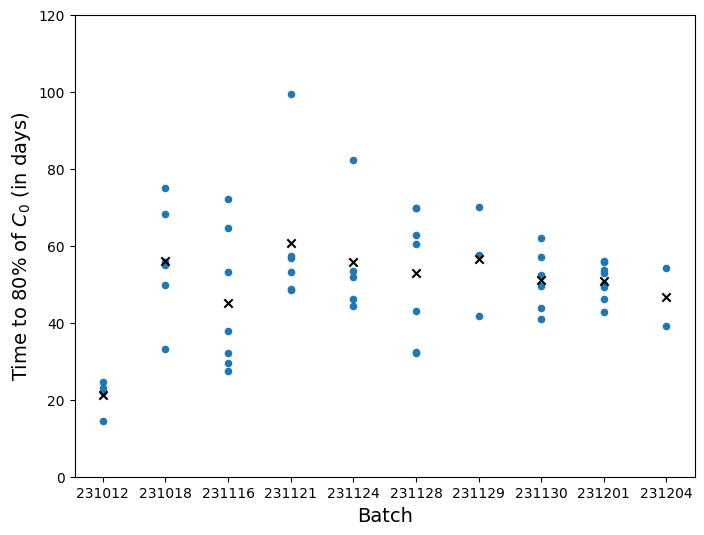

In [885]:
_, ax = plt.subplots(figsize=(8, 6))

# for w in np.arange(0, 20000, 10):
#     # print(w)
#     df_T = df.assign(cost_t=df[T_KEY])

#     min_df_T = df.iloc[df_T["cost_t"].astype(float).idxmin()]
#     # display(min_df_T)
#     # break

#     x, y = w, min_df_T[E_KEY]
#     ax.plot(x, y, ".", label=f"{min_df_T['formation_cycles']} | {min_df_T['additive_amount']}% {min_df_T['additive_type']}")

# plt.xlabel('Weight')
# plt.ylabel('Score')

# ax.legend()

# cost functions
dfs = df.assign(cost_t=1 / df[T_KEY] /
                24).sort_values("batch").reset_index(drop=True)

avg = dfs.groupby(["batch", "voltage"])["cost_t"].mean().reset_index()

dfs.plot.scatter(x="batch", y="cost_t", ax=ax)
ax.scatter(avg["batch"], avg["cost_t"], color='k', marker="x")
# dfs

ax.set_ylim(0, 120)
ax.set_xlabel("Batch", fontsize=14)
ax.set_ylabel(r"Time to 80% of $C_0$ (in days)", fontsize=14)


In [830]:
avg


,batch,voltage,cost_t
0,231012,4.2,21.097257
1,231018,4.2,56.160923
2,231116,4.4,25.716689
3,231121,4.2,60.668931
4,231124,4.2,55.666458
5,231128,4.2,52.925212
6,231129,4.2,56.464838
7,231130,4.2,50.979377
8,231201,4.4,29.791269
9,231204,4.2,46.719249


In [ ]:
# normalization
# for key in (E_KEY, T_KEY):
#     df[key] /= df[key].max()
    # df[key] = MinMaxScaler().fit_transform(df[key].to_numpy().reshape(-1, 1))

_, ax = plt.subplots()

# for w in np.arange(0, 20000, 10):
#     # print(w)
#     df_T = df.assign(cost_t=df[T_KEY])

#     min_df_T = df.iloc[df_T["cost_t"].astype(float).idxmin()]
#     # display(min_df_T)
#     # break

#     x, y = w, min_df_T[E_KEY]
#     ax.plot(x, y, ".", label=f"{min_df_T['formation_cycles']} | {min_df_T['additive_amount']}% {min_df_T['additive_type']}")

# plt.xlabel('Weight')
# plt.ylabel('Score')

# ax.legend()

# cost functions
dfs = df.assign(
    # cost_E=0.5 * df["formation_cycles"] + 0.5 / df[E_KEY],
    cost_t=df[T_KEY],
).sort_values("batch").reset_index(drop=True)

avg = dfs.groupby("batch")["cost_t"].mean().reset_index()

dfs.plot.scatter(x="batch", y="cost_t", ax=ax)
ax.plot(avg["batch"], avg["cost_t"], 'k')
# dfs


In [ ]:
# # df = pd.DataFrame(collected)

# for batch in ec_lab_batches:

#     I_data = excel_data[batch]["I"]
#     Q_data = excel_data[batch]["Q"]
#     E_data = excel_data[batch]["E"]

#     capacities = Q_data.replace(0, np.nan).iloc[1:, 1::2]
#     cycles = capacities.apply(lambda col: col.last_valid_index())

#     meta = Q_data.columns.str.extract(r"(\d{6}-\d+-\d+)").dropna()
#     meta = meta[0].str.split("-", expand=True)
#     meta.rename({0: "batch", 1: "number", 2: "voltage"}, axis=1, inplace=True)
#     meta["voltage"] = meta["voltage"].apply(lambda v: f"4.{v}").astype(float)
#     meta = meta.sort_values(["batch", "voltage"]).reset_index(drop=True)
#     additive = generations[batch]["additive"]
#     meta = meta.assign(
#         additive_type=additive["type"],
#         additive_amount=additive["amount"],
#         formation_cycles=generations[batch]["formation_cycles"],
#     )
#     meta["long_term_cycles"] = cycles.values
#     # meta = meta[~meta["voltage"].isin((4.6, 4.8))]
#     meta = meta[meta["long_term_cycles"] >= E_CYCLE]
#     meta.drop("long_term_cycles", axis=1, inplace=True)
#     # display(meta)
#     # break

#     columns = [
#         "Battery_Number",
#         "Cathode Weight (mg)",
#         "Cathode Current Collector Weight (mg)",
#     ]

#     weights = pd.read_csv(
#         f"{ROOT}/robot_outputs/{batch}_robot_output.csv",
#         sep=";",
#     )[columns].astype({"Battery_Number": str})

#     df_E = E_data.iloc[1:E_CYCLE + 1, 1::2].sum()
#     df_E = df_E.reset_index(drop=True).rename(E_KEY)
#     # display(df_E)

#     df3 = pd.concat((meta, df_E), axis=1).dropna().reset_index(drop=True)
#     df3 = pd.merge(df3, weights, left_on="number", right_on="Battery_Number")
#     cat_weight_tot = df3["Cathode Weight (mg)"]
#     cat_weight_cc = df3["Cathode Current Collector Weight (mg)"]
#     df3[E_KEY] /= (cat_weight_tot - cat_weight_cc) / 1000
#     df3.drop(columns, axis=1, inplace=True)
#     df3 = df3.astype({"formation_cycles": int})
#     # display(df3)

#     pattern = r"\d{6}-(\d+)"
#     samples = I_data.columns.str.extract(pattern).dropna().values.flatten()
#     t80 = dict.fromkeys(samples, [])

#     for i in range(0, len(I_data.columns), 2):

#         data = process_data(I_data.iloc[1:, i:i + 2])

#         shift = np.argmax(data["Qd"])  # maximum capacity cycle

#         C0 = data["Qd"][shift]  # [mAh]

#         c_cycle = C_CYCLE + shift
#         C = data["Qd"][c_cycle - 1]  # [mAh]

#         idx = data["cycle-index"]
#         start, end = idx[shift], idx[c_cycle]
#         ts, te = data["time"][start] / 3600, data["time"][end] / 3600  # [h]
#         td = te - ts
#         t80[samples[i // 2]] = 0.2 * (C0 * td) / (C0 - C) + ts  # [h]

#     t80 = pd.DataFrame({"number": t80.keys(), T_KEY: t80.values()})
#     t80[T_KEY] = 1 / t80[T_KEY]

#     df4 = pd.merge(df3, t80)

#     df = pd.concat((df, df4)).reset_index(drop=True)
#     df.reset_index(drop=True, inplace=True)

# # df


In [ ]:
# _, ax = plt.subplots()

# xt, yt = [], []

# for (
#         label,
#         cathode_weight,
#         formation_protocol,
#         long_term_protocol,
#         results,
# ) in items:

#     Q_data = get_data_from_results(results)

#     x, y = Q_data["cycle-number"], Q_data["Qd"]

#     xt.append(x)
#     yt.append(y)

#     ax.plot(x, y, '.', label=label)

# xc = np.concatenate(xt)
# yc = np.concatenate(yt)

# poly = PolynomialFeatures(degree=7, include_bias=False)
# poly_features = poly.fit_transform(xc.reshape(-1, 1))

# best_fit_line = RANSACRegressor().fit(poly_features, yc)
# prediction = best_fit_line.predict(poly_features)

# ax.plot(xc, prediction, "k.", markersize=1, label="fitted")
# plt.legend()


In [ ]:
# _, ax = plt.subplots()

# for (
#         label,
#         cathode_weight,
#         formation_protocol,
#         long_term_protocol,
#         results,
# ) in items:

#     # if label != "231012-2":
#     #     continue

#     Q_data = get_data_from_results(results)
#     x, y = Q_data["cycle-number"], Q_data["Qd"]

#     line, = ax.plot(x, y, ".", label=label)

#     target = .8 * max(y)  # 80% capacity

#     if y[-1] > target:
#         avg_diff = np.mean(y - prediction[:len(y)])
#         idx = np.argmin(np.abs(prediction + avg_diff - target))
#         cycle = xc[idx]
#         ax.plot(xc[:idx], prediction[:idx] + avg_diff, ".", markersize=1, color=line.get_color())
#     else:
#         idx = np.argmin(np.abs(y - target))
#         cycle = x[idx]

#     print(f"{label:9s} | C0 = {max(y):0.2f} mAh -> 80% = {target:0.2f} mAh @ cycle {cycle}")

# plt.legend()


In [ ]:
# best_fits = []

# _, ax = plt.subplots()

# xt, yt = [], []

# for (
#         label,
#         cathode_weight,
#         formation_protocol,
#         long_term_protocol,
#         results,
# ) in items:

#     Q_data = get_data_from_results(results)

#     if len(Q_data["Qd"]) < 50:
#         continue

#     x, y = Q_data["cycle-number"], Q_data["Qd"]
#     poly = PolynomialFeatures(degree=3, include_bias=False)
#     poly_features = poly.fit_transform(x.reshape(-1, 1))

#     best_fit_line = RANSACRegressor().fit(poly_features, y)
#     best_fits.append(best_fit_line)
#     # best_fits.append((best_fit_line.coef_[0], best_fit_line.intercept_))

#     pd.DataFrame({"x": x, "y": y}).plot.scatter(x="x", y="y", ylim=(0, 2), ax=ax)
#     plt.plot(x, best_fit_line.predict(poly_features), "red")


In [ ]:
# """
# Given the following function:
#     y = f(w1:w6) = w1x1 + w2x2 + w3x3 + w4x4 + w5x5 + 6wx6
#     where (x1,x2,x3,x4,x5,x6)=(4,-2,3.5,5,-11,-4.7) and y=44
# What are the best values for the 6 weights (w1 to w6)? We are going to use the genetic algorithm to optimize this function.
# """

# function_inputs = [4, -2, 3.5, 5, -11, -4.7]  # Function inputs.
# desired_output = 44  # Function output.


# def fitness_func(ga_instance, solution, solution_idx):
#     output = np.sum(solution * function_inputs)
#     fitness = 1.0 / (np.abs(output - desired_output) + 0.000001)
#     return fitness


# num_generations = 100  # Number of generations.
# num_parents_mating = 10  # Number of solutions to be selected as parents in the mating pool.

# sol_per_pop = 20  # Number of solutions in the population.
# num_genes = len(function_inputs)

# last_fitness = 0


# def on_generation(ga_instance):
#     global last_fitness
#     print(
#         f"Generation = {ga_instance.generations_completed} | Fitness = {ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]} | Change = {ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness}"
#     )
#     last_fitness = ga_instance.best_solution(
#         pop_fitness=ga_instance.last_generation_fitness)[1]


# ga_instance = pygad.GA(num_generations=num_generations,
#                        num_parents_mating=num_parents_mating,
#                        sol_per_pop=sol_per_pop,
#                        num_genes=num_genes,
#                        fitness_func=fitness_func,
#                        on_generation=on_generation)

# # Running the GA to optimize the parameters of the function.
# ga_instance.run()

# ga_instance.plot_fitness()

# # Returning the details of the best solution.
# solution, solution_fitness, solution_idx = ga_instance.best_solution(
#     ga_instance.last_generation_fitness)
# print(f"Parameters of the best solution : {solution}")
# print(f"Fitness value of the best solution = {solution_fitness}")
# print(f"Index of the best solution : {solution_idx}")

# prediction = np.sum(np.array(function_inputs) * solution)
# print(f"Predicted output based on the best solution : {prediction}")

# if ga_instance.best_solution_generation != -1:
#     print(
#         f"Best fitness value reached after {ga_instance.best_solution_generation} generations."
#     )

# # Saving the GA instance.
# filename = 'genetic'  # The filename to which the instance is saved. The name is without extension.
# ga_instance.save(filename=filename)

# # Loading the saved GA instance.
# loaded_ga_instance = pygad.load(filename=filename)
# loaded_ga_instance.plot_fitness()
